# Antidepressant exposure sample sizes

In [2]:
library(readr)
library(dplyr)
library(stringr)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
bucket <- Sys.getenv("WORKSPACE_BUCKET")
billing <- Sys.getenv("GOOGLE_PROJECT")

## Exposure phenoypes

In [4]:
system(str_glue("gsutil -m cp {bucket}/inputs/atc_antidep.* ."))

In [4]:
pheno <- read_tsv("atc_antidep.pheno")
covar <- read_tsv("atc_antidep.covar")

Rows: 206173 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
dbl (5): FID, IID, N06A, N06AA, N06AB

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 206161 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): gender
dbl (12): FID, IID, PC1_AVG, PC2_AVG, PC3_AVG, PC4_AVG, PC5_AVG, PC6_AVG, PC...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Genetics auxiliary files

In [7]:
system(str_glue("gsutil -m -u {billing} cp gs://fc-aou-datasets-controlled/v7/wgs/short_read/snpindel/aux/ancestry/ancestry_preds.tsv ."))
system(str_glue("gsutil -m -u {billing} cp gs://fc-aou-datasets-controlled/v7/wgs/short_read/snpindel/aux/qc/flagged_samples.tsv ."))

In [5]:
ancestry <- read_tsv("ancestry_preds.tsv")
flagged <- read_tsv("flagged_samples.tsv")

Rows: 245394 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): ancestry_pred, probabilities, pca_features, ancestry_pred_other
dbl (1): research_id

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 549 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): ancestry_pred, probabilities, pca_features, ancestry_pred_other, qc...
dbl (9): s, snp_count, ins_del_ratio, del_count, ins_count, snp_het_homvar_r...
lgl (8): fail_snp_count_residual, fail_ins_del_ratio_residual, fail_del_coun...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Sample sizes

In [6]:
pheno_cover_cluster <-
pheno |>
    inner_join(ancestry, by = c("IID" = "research_id")) |>
    inner_join(covar, by = c("FID", "IID")) |>
    select(FID, IID, starts_with("N06A"), ancestry_pred, starts_with("PC"), -pca_features)

In [15]:
pheno_cover_cluster |>
    count(ancestry_pred, N06A)

ancestry_pred,N06A,n
<chr>,<dbl>,<int>
afr,0,32478
afr,1,13291
amr,0,27879
amr,1,8270
eas,0,3554
eas,1,672
eur,0,72790
eur,1,43860
mid,0,621


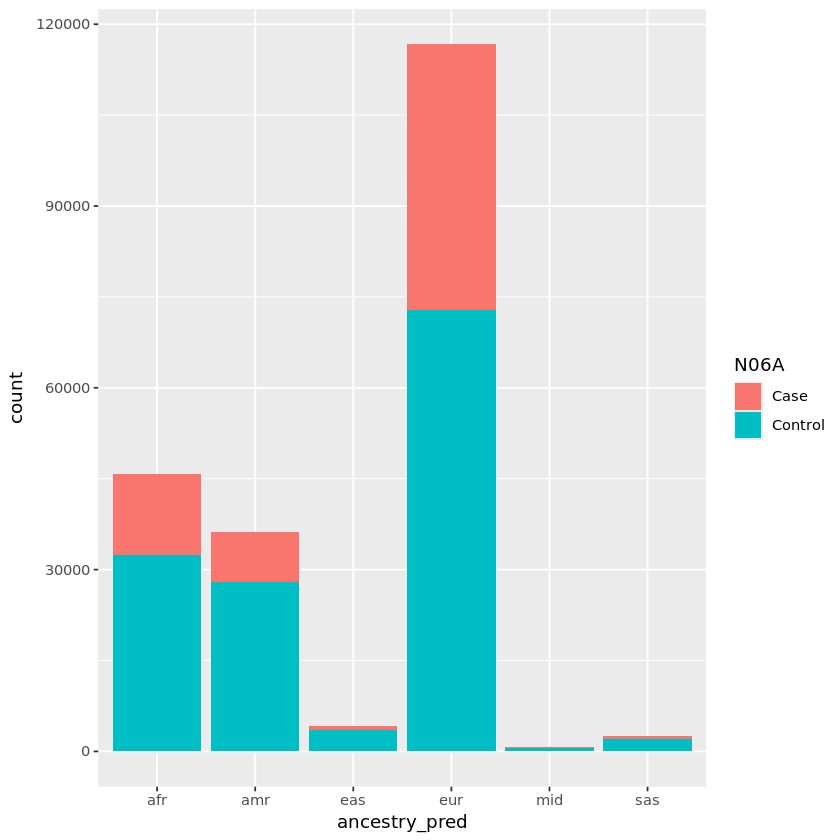

In [46]:
ggplot(mutate(pheno_cover_cluster, N06A = if_else(N06A == 1, true = "Case", false = "Control")),
              aes(x = ancestry_pred, group = N06A, fill = N06A)) +
    geom_bar()

In [39]:
pheno_cover_cluster |>
    count(ancestry_pred, N06AA)

ancestry_pred,N06AA,n
<chr>,<dbl>,<int>
afr,0,42066
afr,1,3706
amr,0,33847
amr,1,2305
eas,0,4086
eas,1,140
eur,0,106054
eur,1,10602
mid,0,758


In [40]:
pheno_cover_cluster |>
    count(ancestry_pred, N06AB)

ancestry_pred,N06AB,n
<chr>,<dbl>,<int>
afr,0,37853
afr,1,7919
amr,0,30949
amr,1,5203
eas,0,3795
eas,1,431
eur,0,88013
eur,1,28643
mid,0,692


## Covariates

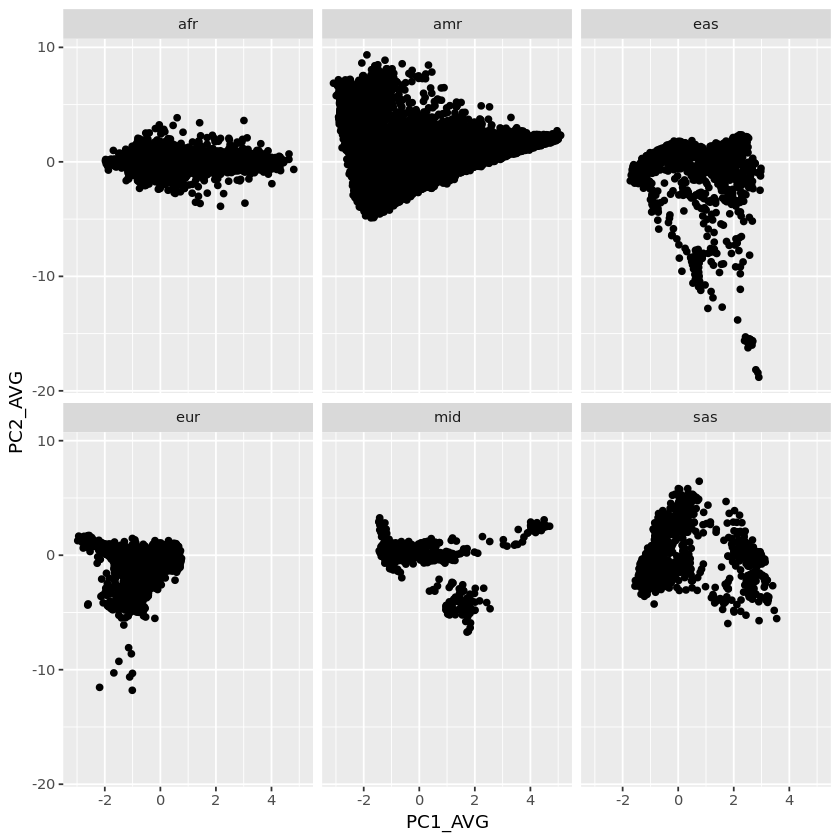

In [21]:
ggplot(pheno_cover_cluster, aes(x = PC1_AVG, y = PC2_AVG)) +
    geom_point() +
    facet_wrap(~ancestry_pred)

In [14]:
clusters <- pheno_cover_cluster |>
    distinct(ancestry_pred) |>
    pull(ancestry_pred)
names(clusters) <- clusters

In [12]:
n06a_pcs_formula <- as.formula(str_c("N06A ~ ", str_c("PC", 1:10, "_AVG", sep = "", collapse = " + ")))

In [19]:
n06a_pcs_m_list <-
lapply(clusters, function(clust) {

glm(n06a_pcs_formula,
            family = "binomial",
            data = filter(pheno_cover_cluster, ancestry_pred == clust))
    })

In [20]:
lapply(n06a_pcs_m_list, summary)

$eur

Call:
glm(formula = n06a_pcs_formula, family = "binomial", data = filter(pheno_cover_cluster, 
    ancestry_pred == clust))

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -5.076e-01  6.055e-03 -83.822  < 2e-16 ***
PC1_AVG      6.750e-02  1.087e-02   6.210 5.31e-10 ***
PC2_AVG      8.684e-02  1.771e-02   4.905 9.35e-07 ***
PC3_AVG      3.470e-03  8.164e-03   0.425  0.67078    
PC4_AVG      4.997e-02  7.755e-03   6.443 1.17e-10 ***
PC5_AVG      1.112e-02  8.367e-03   1.329  0.18371    
PC6_AVG      1.537e-02  9.438e-03   1.629  0.10335    
PC7_AVG      2.903e-02  9.405e-03   3.087  0.00202 ** 
PC8_AVG      1.195e-02  9.072e-03   1.317  0.18791    
PC9_AVG      9.798e-03  9.075e-03   1.080  0.28029    
PC10_AVG    -3.092e-05  8.860e-03  -0.003  0.99722    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 154461  on 116649  degrees of freedom
Residual dev